In [ ]:
# create, login to Kaggle, click your account logo at the top right, go to settings, click 'create new token', this file should download as kaggle.json
# dataset link: https://www.kaggle.com/datasets/abhijimenon/narutocharactersdataset
from google.colab import files
files.upload()  # Upload 'kaggle.json' here (API key from Kaggle)

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

!kaggle datasets download -d abhijimenon/narutocharactersdataset
!unzip /content/narutocharactersdataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: naruto_character_dataset/itachi/itachi115.jpg  
  inflating: naruto_character_dataset/itachi/itachi116.jpg  
  inflating: naruto_character_dataset/itachi/itachi117.jpg  
  inflating: naruto_character_dataset/itachi/itachi118.jpg  
  inflating: naruto_character_dataset/itachi/itachi119.jpg  
  inflating: naruto_character_dataset/itachi/itachi120.jpg  
  inflating: naruto_character_dataset/itachi/itachi121.jpg  
  inflating: naruto_character_dataset/itachi/itachi122.jpg  
  inflating: naruto_character_dataset/itachi/itachi123.jpg  
  inflating: naruto_character_dataset/itachi/itachi124.jpg  
  inflating: naruto_character_dataset/itachi/itachi125.jpg  
  inflating: naruto_character_dataset/itachi/itachi126.jpg  
  inflating: naruto_character_dataset/itachi/itachi127.jpg  
  inflating: naruto_character_dataset/itachi/itachi128.jpg  
  inflating: naruto_character_dataset/itachi/itachi129.jpg  
  inflating: naruto_character_data

In [ ]:
#click folder icon to the left of colabs, click the 3 dots next to naruto_character_dataset, then click copy path, paste this path below in the path

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import resnet18

data_dir = '/content/naruto_character_dataset'  # Adjust the path as necessary

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [ ]:
model = resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(5):  # 5 epochs for demo; adjust as needed
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# Save the trained model
torch.save(model.state_dict(), 'naruto_resnet18.pth')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 36.6MB/s]


Epoch 1, Loss: 0.7958351212834555
Epoch 2, Loss: 0.4794216995674466
Epoch 3, Loss: 0.37916540709279833
Epoch 4, Loss: 0.30579059943556786
Epoch 5, Loss: 0.21466984843746537


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 84.86%


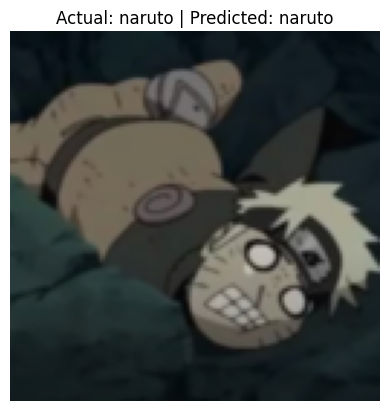

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image

# Assuming you have a trained model
model.eval()

# Prepare a transformation pipeline similar to training
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load a single image from the test dataset
test_image, test_label = test_dataset[0]
test_image_tensor = test_image.unsqueeze(0).to(device)

# Make a prediction
with torch.no_grad():
    output = model(test_image_tensor)
    _, predicted = torch.max(output, 1)
    predicted_label = predicted.item()

# Reverse the normalization for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)
test_image_np = inv_normalize(test_image).permute(1, 2, 0).cpu().numpy()

# Get class names
class_names = dataset.classes

# Plot the image with predicted and actual labels
plt.imshow(test_image_np)
plt.title(f'Actual: {class_names[test_label]} | Predicted: {class_names[predicted_label]}')
plt.axis('off')
plt.show()
